# Use OSMnx to get street networks by place name

Author: [Geoff Boeing](https://geoffboeing.com/)

  - [Overview of OSMnx](http://geoffboeing.com/2016/11/osmnx-python-street-networks/)
  - [GitHub repo](https://github.com/gboeing/osmnx)
  - [Examples, demos, tutorials](https://github.com/gboeing/osmnx-examples)
  - [Documentation](https://osmnx.readthedocs.io/en/stable/)
  - [Journal article/citation](http://geoffboeing.com/publications/osmnx-complex-street-networks/)
  
Once you've perused the features demo and overview notebooks, this notebook provides further demonstration of querying by place name with OSMnx.

In [1]:
import osmnx as ox
%matplotlib inline
ox.config(log_console=True, use_cache=True)
ox.__version__

'0.13.0'

## 1. Query/download place boundaries

The `graph_from_place` function uses place boundary geocoding logic to find the network within your place's boundary. Let's look briefly at this place boundary querying before we get to street networks. You can download by cities, neighborhoods, boroughs, counties, states, or countries: anything with geocodable polygon boundaries in OSM's database. Notice the polygon geometries represent political boundaries, not physical/land boundaries.

In [2]:
# neighborhoods or boroughs
gdf = ox.gdf_from_place('Manhattan, New York, New York, USA')

# counties
gdf = ox.gdf_from_place('Cook County, Illinois, United States')

# states
gdf = ox.gdf_from_place('Iowa')

In [3]:
# you can also buffer the place boundaries (0.5 km in this example)
gdf = ox.gdf_from_place('Piedmont, California, USA', buffer_dist=500)

In [4]:
# you can get multiple places in a single query
gdf = ox.gdf_from_places(['United Kingdom', 'Ireland'])

# and optionally buffer them
places = ['Berkeley, California, USA', 
          'Oakland, California, USA',
          'Piedmont, California, USA',
          'Emeryville, California, USA',
          'Alameda, Alameda County, CA, USA']
gdf = ox.gdf_from_places(places, buffer_dist=500)

### Be careful to pass the right place name to get what you want

Be specific and explicit, and sanity check the results. Try passing a dict instead of a string to be more explicit.

In [5]:
# oops, this gets the county of alameda rather than the city!
alameda1 = ox.gdf_from_place('Alameda, California, USA')

# this gets the city of alameda
alameda2 = ox.gdf_from_place({'city'   : 'Alameda',
                              'county' : 'Alameda County',
                              'state'  : 'California',
                              'country': 'USA'})

# the city is a very small part of the county
alameda1 = ox.projection.project_gdf(alameda1)
alameda2 = ox.projection.project_gdf(alameda2)
alameda2.area.iloc[0] / alameda1.area.iloc[0]

0.02791767205093063

OSM resolves 'Mexico' to Mexico City and returns a single point at the center of the city. If we want the boundaries of the country of Mexico, we can pass a dict containing a structured query to specify that we want Mexico the country instead of Mexico the city.

In [6]:
mexico = ox.gdf_from_place('Mexico')
type(mexico['geometry'].iloc[0])

shapely.geometry.point.Point

In [7]:
# instead of a string, you can pass a dict containing a structured query
mexico = ox.gdf_from_place({'country':'Mexico'})

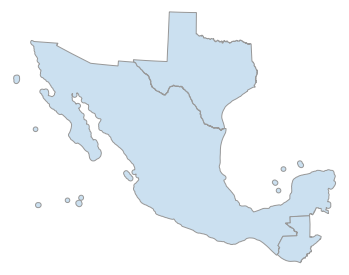

In [8]:
# you can pass multiple queries with mixed types (dicts and strings)
mx_gt_tx = ox.gdf_from_places(queries=[{'country':'Mexico'}, 'Guatemala', {'state':'Texas'}])
fig, ax = ox.plot_shape(ox.projection.project_gdf(mx_gt_tx))

### You can request a specific result number

By default, we only request one result from OSM. But, we can pass an optional `which_result` parameter to query OSM for *n* results and then process/return the *n*th. If you query 'France', OSM returns the country with all its overseas territories as result 1 and European France alone as result 2. Querying for 'France' returns just the first result, but passing `which_result=2` instead retrieves the top 2 results from OSM and processes/returns the 2nd one. You could have also done this to retrieve Mexico the country instead of Mexico City above.

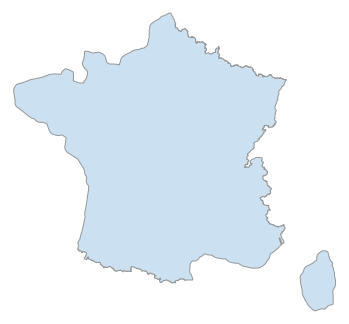

In [9]:
france = ox.gdf_from_place('France', which_result=2)
fig, ax = ox.plot_shape(ox.projection.project_gdf(france))

## 2. Get street networks by place name

This "by place" querying logic works the same as the place boundary querying we just saw above.

In [10]:
# get the walking network for piedmont
G = ox.graph_from_place('Piedmont, California, USA', network_type='walk')

In [11]:
# you can also get a network with a buffer distance (meters) around the place
G = ox.graph_from_place('Piedmont, California, USA', network_type='walk', buffer_dist=200)

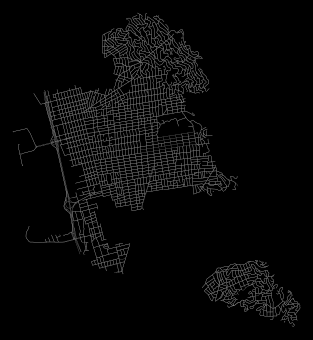

In [12]:
# create a network from multiple places
places = ['Piedmont, California, USA', 
          'Berkeley, California, USA',
          'Emeryville, California, USA']

# use retain_all if you want to keep all disconnected subgraphs (e.g. when your places aren't adjacent)
G = ox.graph_from_place(places, network_type='drive', retain_all=True)
fig, ax = ox.plot_graph(G, node_size=0, edge_linewidth=0.25, bgcolor='k')

In [13]:
# or create a network from structured place queries
places = [{'city':'Daly City', 'state':'California'}, 
         {'city':'South San Francisco', 'state':'California'}]
G = ox.graph_from_place(places, network_type='drive')

In [14]:
# get the network for the borough of manhattan
G = ox.graph_from_place('Manhattan, New York, New York, USA', network_type='drive')

In [15]:
# get the network for the financial district neighborhood in downtown LA
place = 'Financial District, Los Angeles, California, USA'
G = ox.graph_from_place(place, which_result=2, network_type='drive')

In [16]:
%%time
# get the network for all of LA
# takes a couple minutes to do all the downloading and processing
place = 'Los Angeles, California, USA'
G = ox.graph_from_place(place, network_type='drive', simplify=False, retain_all=True)

CPU times: user 29.8 s, sys: 452 ms, total: 30.2 s
Wall time: 30.2 s


Note that if you want a projected network, it's usually faster for large cities to say simplify=False, then project the graph, then simplify it. Projecting a simplified graph with spatial geometries embedded as edge attributes can take a *long* time in large networks.

In [17]:
# create a network constrained to the shape of hong kong island
G = ox.graph_from_place('Hong Kong Island', network_type='drive')